In [1]:
import pandas as pd
df= pd.read_json('dblp-ref-0.json', lines=True)
#print(df)

                                                 abstract  \
0       The purpose of this study is to develop a lear...   
1       This paper describes the design and implementa...   
2       This article applied GARCH model instead AR or...   
3                                                     NaN   
4                                                     NaN   
...                                                   ...   
999995                                                NaN   
999996  In the last few years, workflow systems have b...   
999997  There are many different designs for audio amp...   
999998  This paper proposes a language acquisition fra...   
999999  Abstract   This thesis investigates the mathem...   

                                                  authors  n_citation  \
0       [Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...           0   
1                             [Gareth Beale, Graeme Earl]          50   
2       [Altaf Hossain, Faisal Zaman, Mohammed N

In [2]:
df.dropna(subset = ["references"], inplace=True)
df.dropna(subset = ["abstract"], inplace=True)
df=df[df['references'].map(lambda d: len(d)) > 0]
df=df.reset_index(drop=True)

In [9]:
#To limit the number of input
data=df.head(10000)
#print(data)

                                               abstract  \
0     The purpose of this study is to develop a lear...   
1     This paper describes the design and implementa...   
2     This article applied GARCH model instead AR or...   
3     Recent achievements in Natural Language Proces...   
4     Most applications of the abstract interpretati...   
...                                                 ...   
9995  In this paper we aim to infer a model of genet...   
9996  This paper describes SYNAPSIS, a parser for pe...   
9997  Motion Estimation (ME) has been developed to r...   
9998  In this paper, we present an approach to a cha...   
9999  Data compression is very important today and i...   

                                                authors  n_citation  \
0     [Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...           0   
1                           [Gareth Beale, Graeme Earl]          50   
2     [Altaf Hossain, Faisal Zaman, Mohammed Nasser,...          50   
3     [

In [58]:
#Collect important information
doc_list = list(data['id'].values)
ref_list = list(data['references'].values)
citation_list = list(data['n_citation'].values)
abstract_list = list(data['abstract'].values)
num_docs = len(doc_list)
#print(len(doc_list))

10000


In [156]:
from top2vec import Top2Vec
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags

def bigrammer(doc):
    sentence_stream = simple_preprocess(strip_tags(doc), deacc=True)
    return bigram_phraser[sentence_stream]

sentence_stream = [doc.split(" ") for doc in  abstract_list]
bigram = Phrases(sentence_stream, min_count=5, threshold=100, delimiter=b' ')
bigram_phraser = Phraser(bigram)

model = Top2Vec(abstract_list,tokenizer=bigrammer,speed="deep-learn")
model.save("Topic-model-dblp-ref-#0")

#print(model.get_num_topics())

2021-11-17 19:04:52,195 - top2vec - INFO - Pre-processing documents for training
2021-11-17 19:04:52,250 - top2vec - INFO - Creating joint document/word embedding
2021-11-17 19:04:53,618 - top2vec - INFO - Creating lower dimension embedding of documents
2021-11-17 19:04:55,322 - top2vec - INFO - Finding dense areas of documents
2021-11-17 19:04:55,343 - top2vec - INFO - Finding topics


In [52]:
from top2vec import Top2Vec
model = Top2Vec.load("Topic-model-dblp-ref-0")

#test: get topics of a document
topic_nums,topic_score,topics_words,word_scores=model.get_documents_topics([0], reduced=False, num_topics=3)
#print(model.get_num_topics())
#print(topic_nums)

78
[[ 7 49 23]]


In [94]:
# Make the raw citation network by networkx
import networkx as nx
G = nx.DiGraph()
for i in range(num_docs):
    topic_nums,topic_score,topics_words,word_scores=model.get_documents_topics([i], reduced=False, num_topics=3)
    G.add_node(doc_list[i],citation=citation_list[i],topics=topic_nums.tolist())
    for j in range(len(ref_list[i])):
        G.add_node(ref_list[i][j])
        G.add_edge(ref_list[i][j],doc_list[i])
print(nx.info(G))

DiGraph with 80518 nodes and 93553 edges


In [95]:
def graph_cleaner(graph,attribute):
    r=nx.DiGraph.to_undirected(graph)
    node_list=[]
    v= nx.get_node_attributes(r,attribute)
    for node in r.nodes:
        if node not in v:
            node_list.append(node)
    graph.remove_nodes_from(node_list)

T=G.copy()
print("before graph processing:",nx.info(T))
graph_cleaner(T,"topics")
print("after cleaning useless nodes:",nx.info(T))
remove = [node for node, degree in dict(T.degree()).items() if degree ==0]
T.remove_nodes_from(remove)
print("after removing single nodes:",nx.info(T))


before graph processing: DiGraph with 80518 nodes and 93553 edges
after cleaning useless nodes: DiGraph with 10000 nodes and 536 edges
after removing single nodes: DiGraph with 905 nodes and 536 edges


In [117]:
#functions for calculating the impact influenced by https://link.springer.com/content/pdf/10.1007/s11192-021-04063-1.pdf

def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

## p2 cited p1, and p1 influenced p2
def paper_citation_relation(g,p1,p2,f1,f2,c1,c2):
    if g.has_edge(p1,p2) and (c1+c2)!=0:
       return (c1/(c1+c2))+jaccard_similarity(f1, f2)
    else: return 0
#f1 is the list of keywords of paper p1
def keyword_citation_relation_raw(fi,fj,f1,f2):
    # if order is important
    #return 1/((f1.index(fi)+1)*(1+f2.index(fj)))
    #if not
    return 1
def keyword_citation_relation_pre(g,p1,p2,f1,f2,c1,c2,fi,fj):
    w_pp=paper_citation_relation(g,p1,p2,f1,f2,c1,c2)
    w_ca_raw=keyword_citation_relation_raw(fi,fj,f1,f2)
    sum=0
    for i in f1:
        for j in f2:
            sum=sum+keyword_citation_relation_raw(i,j,f1,f2)
    return w_pp* w_ca_raw/sum

def keyword_citation_relation(g,fi,fj):
    influence=0
    k=nx.get_node_attributes(g,"topics")
    c=nx.get_node_attributes(g,"citation")
    if fi != fj:
        for node in g.nodes:
            if fi in k[node][0]:
                c1=c[node]
                f1=k[node][0]
                for neighbor in g.neighbors(node):
                    if fj in k[neighbor][0]:
                        c2=c[neighbor]
                        f2=k[neighbor][0]
                        influence=influence+keyword_citation_relation_pre(g,node,neighbor,f1,f2,c1,c2,fi,fj)
        return influence
    else: return 1

#Test the result
#print(keyword_citation_relation(T,3,5))

0.3689775245330801


In [118]:
import numpy as np

def nest_list(list1,rows, columns):
        result=[]
        start = 0
        end = columns
        for i in range(rows):
            result.append(list1[start:end])
            start +=columns
            end += columns
        return result

topic_inf_adj=[]
for topic_i in range(model.get_num_topics()):
    for topic_j in range(model.get_num_topics()):
        #print(topic_i,topic_j)
        topic_inf_adj.append(keyword_citation_relation(T,topic_i,topic_j))

adj_matrix=nest_list(topic_inf_adj,78,78)
adj_matrix = np.array(adj_matrix)

Topic-Impact Graph info: DiGraph with 78 nodes and 2352 edges


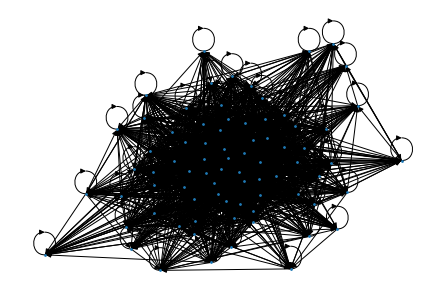

In [148]:
TIG=nx.from_numpy_matrix(adj_matrix, parallel_edges=False, create_using=nx.DiGraph)

print("Topic-Impact Graph info:",nx.info(TIG))

nx.draw(TIG,node_size=3)

Cleaned Topic-Impact Graph info: DiGraph with 78 nodes and 1669 edges


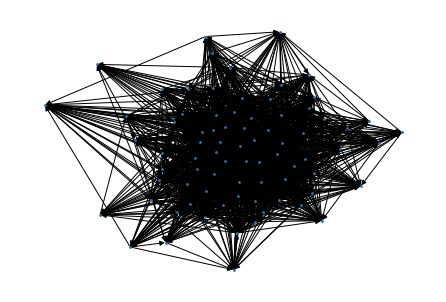

Cleaned Topic-Impact Graph info: DiGraph with 78 nodes and 1669 edges


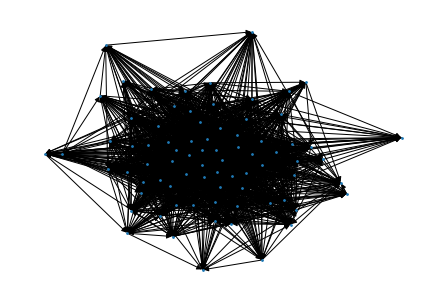

In [150]:
def topic_cleaner(topic_impact_graph,citation_graph):
    rc=nx.DiGraph.to_undirected(topic_impact_graph)
    for node in rc.nodes:
        for neighbor in rc.neighbors(node):
            ab=keyword_citation_relation(citation_graph,node,neighbor)
            ba=keyword_citation_relation(citation_graph,neighbor,node)
            if topic_impact_graph.has_edge(node, neighbor) and topic_impact_graph.has_edge(neighbor, node):
                if ab>=ba:
                    topic_impact_graph.remove_edge(neighbor, node)
                else:
                    topic_impact_graph.remove_edge(node, neighbor)
    return topic_impact_graph

TIG=topic_cleaner(TIG,T)
print("Cleaned Topic-Impact Graph info:",nx.info(TIG))
nx.draw(TIG,node_size=3)

filtered Topic-Impact Graph info: DiGraph with 50 nodes and 94 edges


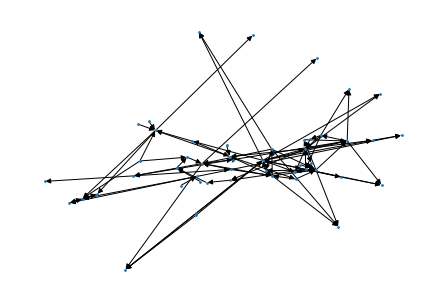

In [153]:
def impact_filter(topic_impact_graph,filter_value):
    rc=topic_impact_graph.copy()
    for (a,b) in rc.edges:
        if (rc.get_edge_data(a, b, default=None)['weight'])<filter_value:
            topic_impact_graph.remove_edge(a, b)
    remove = [node for node, degree in dict(topic_impact_graph.degree()).items() if degree ==0]
    topic_impact_graph.remove_nodes_from(remove)
    return topic_impact_graph

F_TIG=impact_filter(TIG,0.5)
print("filtered Topic-Impact Graph info:",nx.info(F_TIG))
nx.draw(F_TIG,node_size=3)

